In [2]:
# Import necessary libraries
import sys
sys.path.append('../')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Import your custom functions and classes from the vae_module.py
from src.vae_module import flatten
from src.vae_module import VAE
from src.vae_module import train_vae

import selfies as sf
import numpy as np
import pandas as pd


data = pd.read_csv('../data/polymers_dataset.csv', header=None, skiprows=2)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,0,C(Cl)CCC(c1ccccc1)CCC(Cl)C,plastic,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,OC(=O)[C@]([H])(CC1=CC=C(O)C=C1)NC(=O)[C@]([H]...,peptide,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@]([H])1O)...,oligosaccharide,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,C(Cl)CCC(c1ccccc1)C(Cl)CCC,plastic,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,CCC(Cl)CC(Cl)CCCC(C)CCC(c1ccccc1),plastic,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
input_smiles_list = data.iloc[:, 1].tolist()
input_selfies_list = list(map(sf.encoder, input_smiles_list))

# Parameters for encoding
max_len = max(sf.len_selfies(s) for s in input_selfies_list)
alphabet = sf.get_alphabet_from_selfies(input_selfies_list)
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))
vocab_stoi = {symbol: idx for idx, symbol in enumerate(alphabet)}
vocab_itos = {idx: symbol for symbol, idx in vocab_stoi.items()}

# Convert SELFIES to one-hot encoding
input_one_hot_arr = np.array([sf.selfies_to_encoding(s, vocab_stoi, pad_to_len=max_len)[1] for s in input_selfies_list])
input_one_hot_arr

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [4]:
## Convert the "input_one_hot_arr" dataset to tensor
x_train = torch.tensor(input_one_hot_arr, dtype=torch.float32)
x_train

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [5]:
# Flatten the input data using the custom 'flatten' function
# This function takes a 3D tensor 'x_train' and reshapes it into a 2D tensor
width, height, input_dim, flattened_dataset = flatten(x_train)

# Define hyperparameters
batch_size = 64  # Batch size for training
latent_dim = 32  # Dimensionality of the latent space
num_epochs = 500 # Number of training epochs

# Create a PyTorch dataset and data loader for training
train_dataset = TensorDataset(flattened_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a VAE model instance
vae = VAE(input_dim, latent_dim)

#Define the optimizer for training the VAE model
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Train the VAE model using the 'train_vae' function
train_vae(vae, train_loader, optimizer, num_epochs)

Epoch [1/500], Loss: 6253.816424815647
Epoch [2/500], Loss: 3048.723244681816
Epoch [3/500], Loss: 2789.8493588096217
Epoch [4/500], Loss: 2662.007277910923
Epoch [5/500], Loss: 2578.883981757858
Epoch [6/500], Loss: 2508.7644603363133
Epoch [7/500], Loss: 2436.3166011420567
Epoch [8/500], Loss: 2363.0513414554184
Epoch [9/500], Loss: 2317.0278923548412
Epoch [10/500], Loss: 2269.122436446671
Epoch [11/500], Loss: 2235.8008761686438
Epoch [12/500], Loss: 2201.870877150781
Epoch [13/500], Loss: 2170.2419024015726
Epoch [14/500], Loss: 2138.9279346525113
Epoch [15/500], Loss: 2117.0686760066833
Epoch [16/500], Loss: 2100.790320735967
Epoch [17/500], Loss: 2077.0353398514976
Epoch [18/500], Loss: 2056.595715832784
Epoch [19/500], Loss: 2040.7515210721515
Epoch [20/500], Loss: 2025.761781922804
Epoch [21/500], Loss: 2008.7606682555963
Epoch [22/500], Loss: 1995.046915662547
Epoch [23/500], Loss: 1984.8225653858008
Epoch [24/500], Loss: 1972.559675458784
Epoch [25/500], Loss: 1967.108556658

In [6]:
# Generate molecules from the trained VAE
vae.eval()
num_samples = 15  # generate a sample
with torch.no_grad():
    latent_samples = torch.randn(num_samples, latent_dim)
    generated_molecules = vae.decoder(latent_samples)
generated_molecules

tensor([[1.2001e-13, 1.7711e-13, 7.8842e-14,  ..., 4.7478e-13, 3.8093e-13,
         9.7964e-01],
        [8.3958e-11, 6.4643e-11, 3.7585e-11,  ..., 4.9250e-11, 8.4730e-11,
         1.0000e+00],
        [1.0185e-09, 7.2722e-10, 7.5392e-10,  ..., 1.1453e-09, 9.0232e-10,
         1.8667e-02],
        ...,
        [4.5445e-15, 1.0704e-15, 3.3939e-15,  ..., 1.7045e-15, 2.0069e-15,
         1.0000e+00],
        [9.5348e-12, 3.1072e-12, 6.0269e-12,  ..., 6.9870e-12, 9.7314e-12,
         1.0000e+00],
        [8.7511e-06, 9.5959e-06, 1.0115e-05,  ..., 1.0439e-05, 8.2033e-06,
         1.0000e+00]])

In [7]:
# Reshape satisfying_molecules_tensor back to a 3D tensor
generated_molecules_tensor_3d = generated_molecules.view(-1, width, height)

# Convert the PyTorch 3D tensor to a NumPy array
generated_molecules_numpy = generated_molecules_tensor_3d.numpy()

max_values = np.max(generated_molecules_numpy, axis=2, keepdims=True)
generated_data = np.where(generated_molecules_numpy == max_values, 1, 0)

In [8]:
### Reproduce SMILES list and visualize the output images 
output_smiles_list = []
for i in range (0,len(generated_data)):
    sm = sf.decoder(sf.encoding_to_selfies(generated_data[i].tolist(), vocab_itos, enc_type="one_hot"))
    output_smiles_list.append(sm)
    
output_smiles_list

['O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@@]1([H])O)([H])[C@@]1([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@@]2([H])O)([H])[C@]2([H])O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@@]3([H])O)([H])[C@@]3([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@@]4([H])O)([H])[C@]4([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@@]5([H])O)([H])[C@]5([H])O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@@]6([H])O)([H])[C@@]6([H])O',
 'CCC(C)CCCCCCCCCCCC=CC=CC#CC',
 'O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@@]1([H])O)([H])[C@@]1([H])N[C@@]([C@]([H])(CO)O[C@](O)([H])[C@]2([H])O)([H])[C@]2([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@@]3([H])O)([H])[C@]3([H])O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@@]4([H])N)([H])[C@@]4([H])O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@@]5([H])N)([H])[C@@]5([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@@]6([H])O)([H])[C@]6([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@@]7([H])O)([H])[C@@]7([H])O',
 'OC(=O)[C@]([H])(C1C=CN)C1=O',
 'CCCCCCCCC(C)CCC(C)CCCC=CCC',
 'OC(=O)C(C)(C)CNC(=O)C(C)(C)CNCCC=O',
 'CC=CCCC[H]',
 'OC(=O)[C@]([H])(CCCCCC)NCC(C)CC(C)NC(=

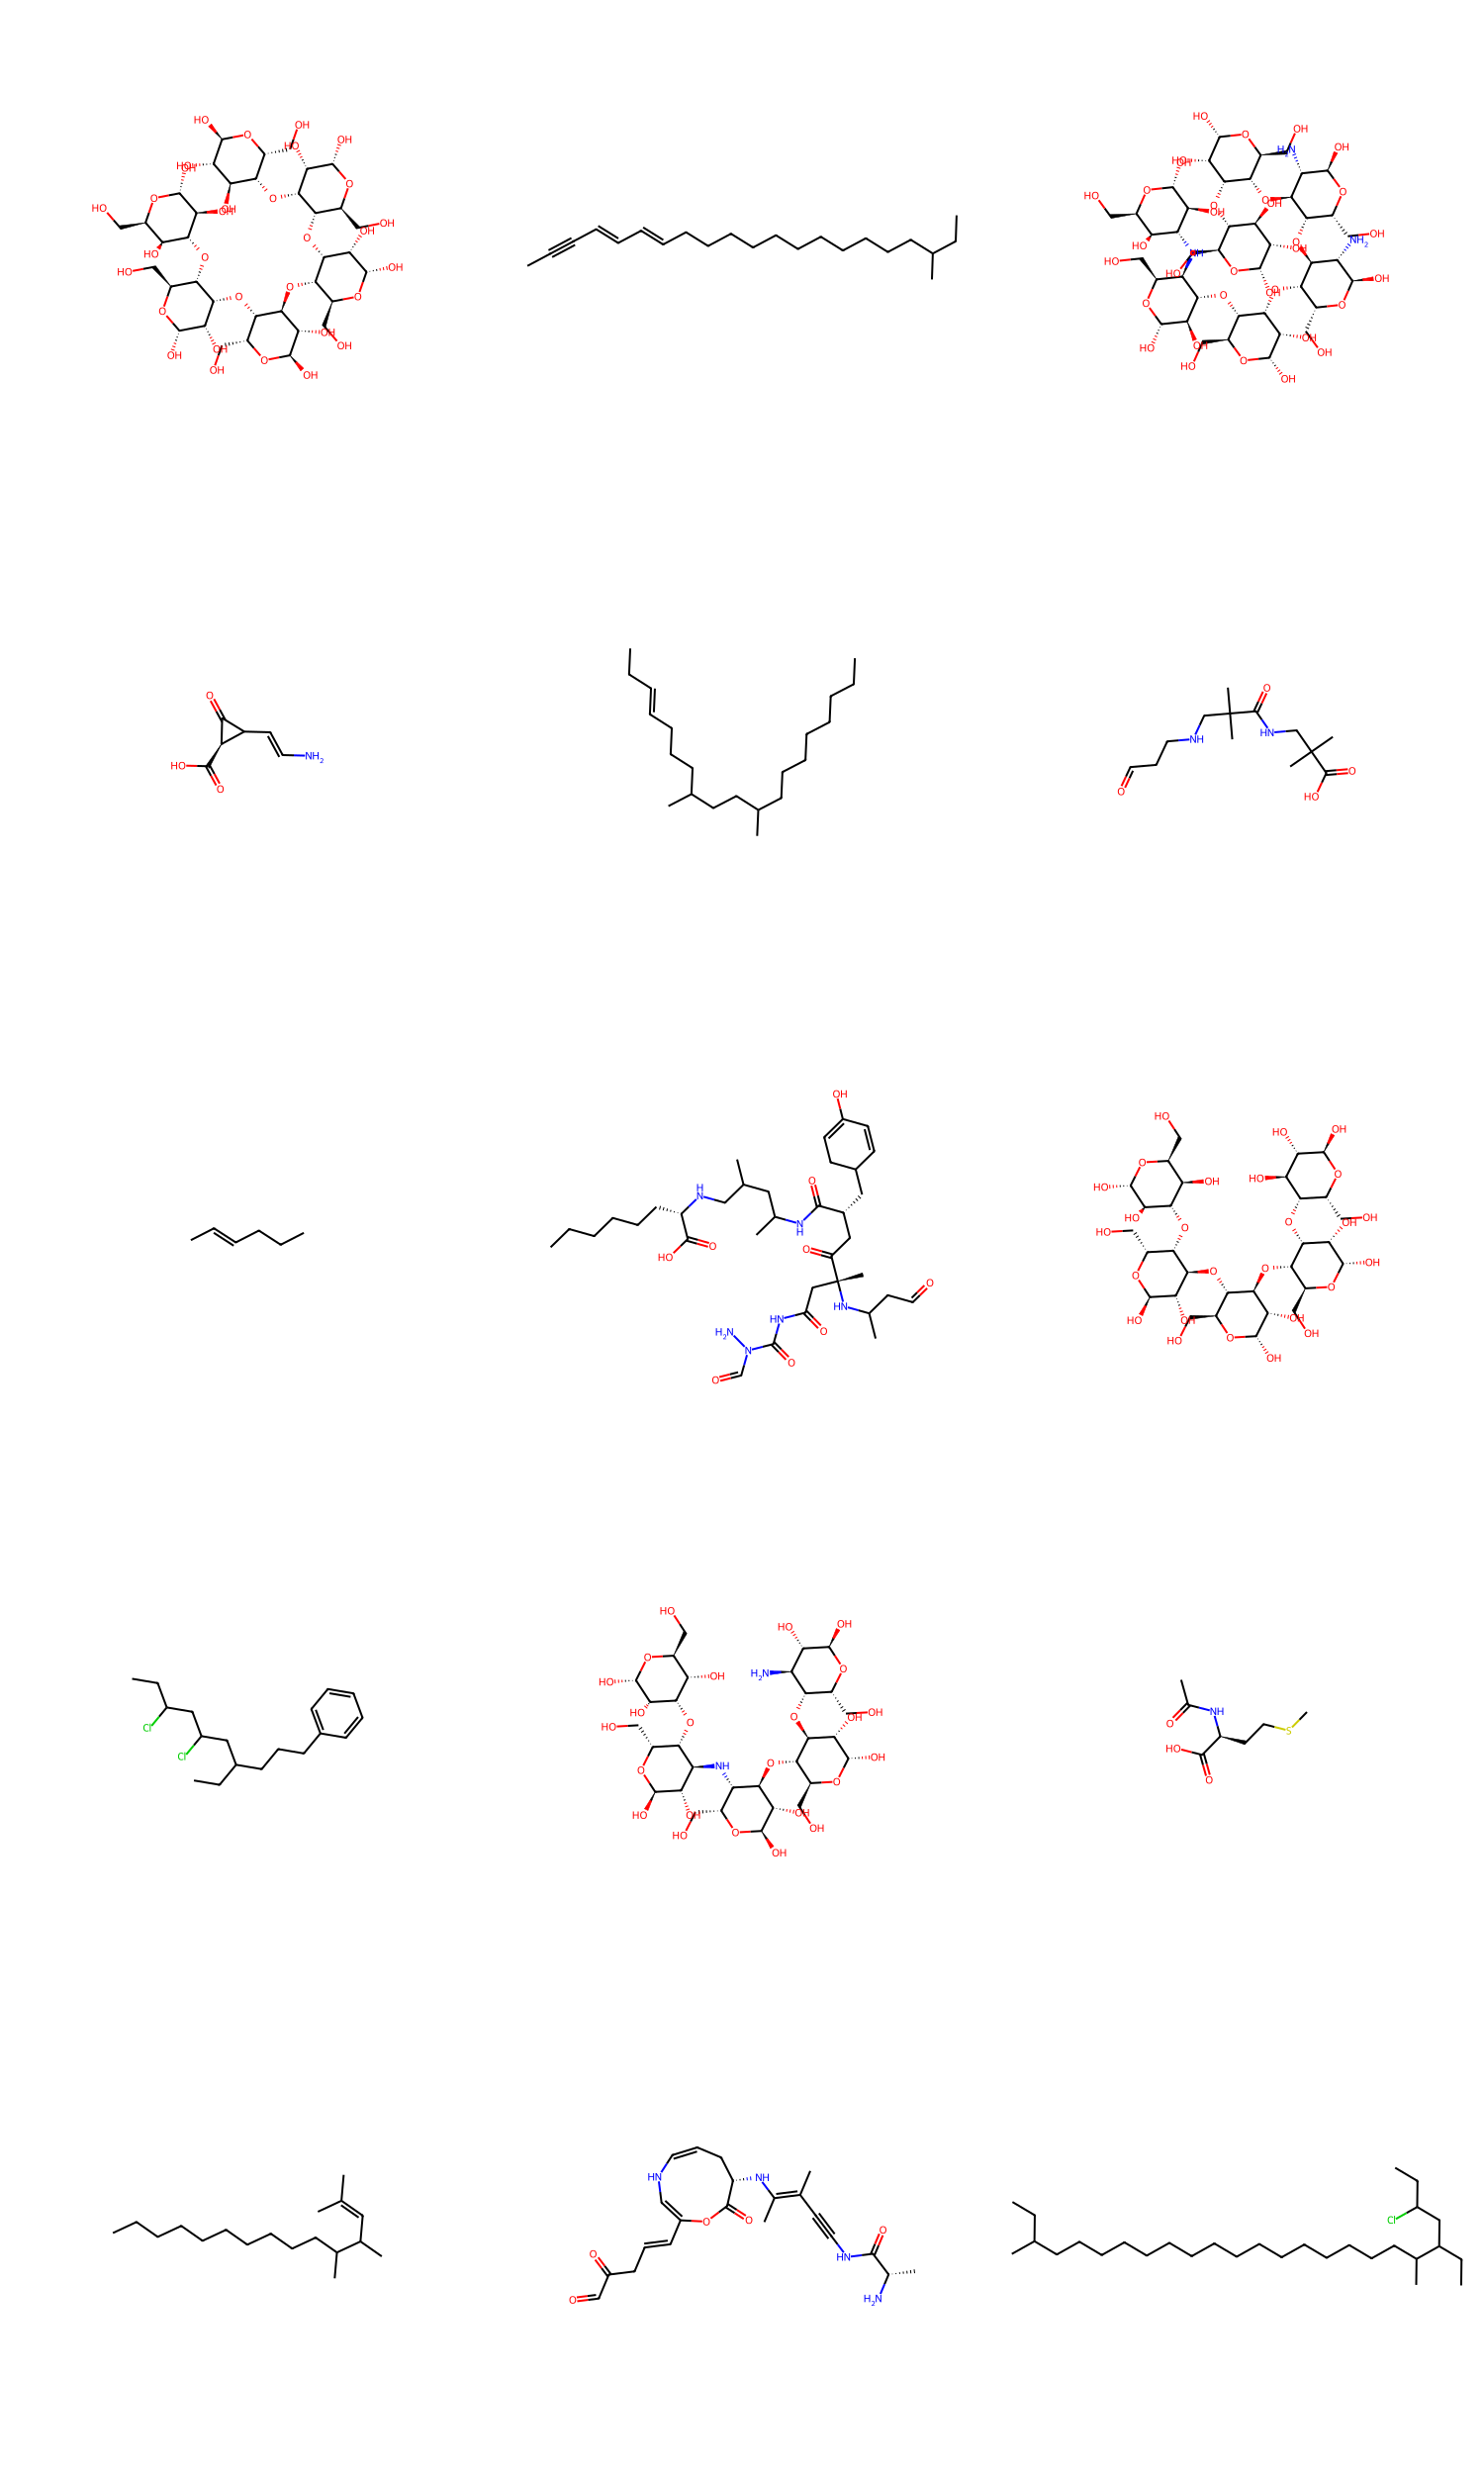

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

output_mol_list = []
for smiles in output_smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    output_mol_list.append(mol)
img = Draw.MolsToGridImage(output_mol_list, subImgSize=(500, 500))
img

In [10]:
# Specify the path to save the .pt file
save_path = "../models/pretrained_vae.pt"

# Save the model to specified path
torch.save(vae.state_dict(), save_path)